In [2]:
import sklearn
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.display import display

In [3]:
pd.options.display.max_rows = 100

In [4]:
dataset_train = pd.read_csv("train.csv")
dataset_test = pd.read_csv("test.csv")

train_y = dataset_train["Survived"]
train_x = dataset_train.drop(["Survived"], axis=1)
combined = pd.concat([train_x, dataset_test], axis=0)
display(combined.describe())
print(combined.shape)

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,3.000000,80.000000,8.000000,9.000000,512.329200


(1309, 11)


# Section 1: Feature enginering

In [5]:
dataset_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


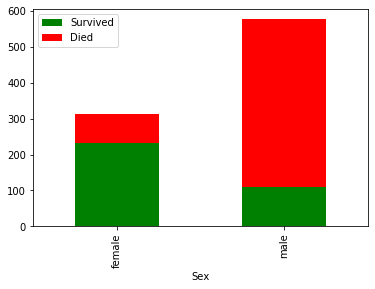

In [6]:
dataset_train["Died"] = 1 - dataset_train["Survived"]
dataset_train.groupby("Sex")[["Survived", "Died"]].sum().plot(kind="bar", 
                                                              stacked=True, 
                                                              color=["g", "r"])
plt.show()

#### Men seem to have more mortality rate rather than women , next we will draw the violin plots

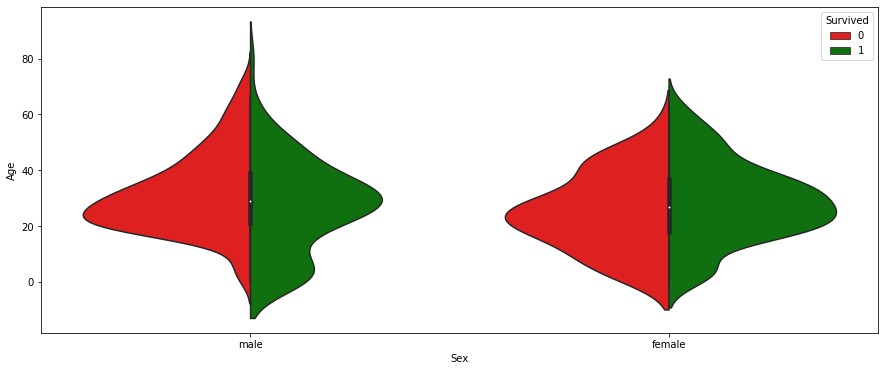

In [7]:
plt.figure(figsize=[15, 6])
sns.violinplot(x="Sex", 
               y="Age",
               hue="Survived",
               data=dataset_train,
               palette={0:"red", 1:"green"},
               split=True
              )
plt.show()

It can be seen that the age does not affect the female population but it affect the male population. Since the youger men have more chance of survival. Now It is time to consider the fair of the tickets.

In [8]:
def plot_feature(name):
    plt.figure(figsize=[15, 8])
    plt.grid(alpha=0.2)
    plt.hist(x = [dataset_train[dataset_train["Survived"] == 0][name], 
                  dataset_train[dataset_train["Survived"] == 1][name]],
             bins = 40,
             color=["r", "g"],
             stacked=True)
    plt.show()

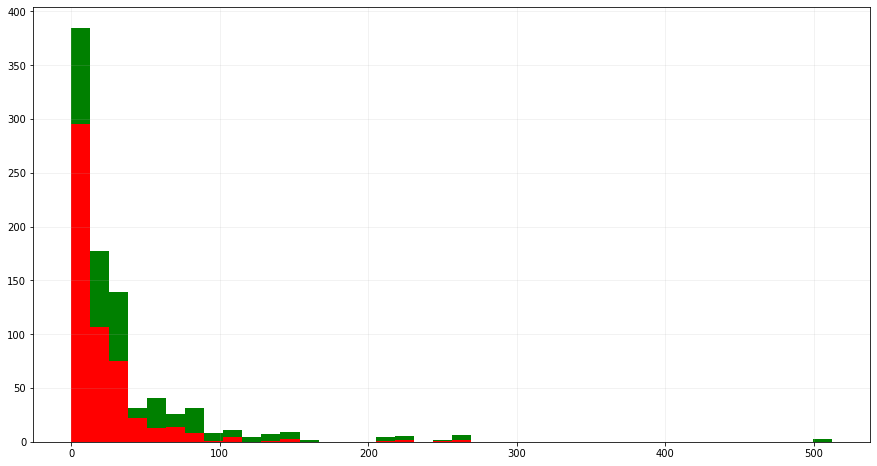

In [9]:
plot_feature("Fare")

Seems like Fare could be a good feature for discrimination sinc ethe low ticket Fares are even more fertile.

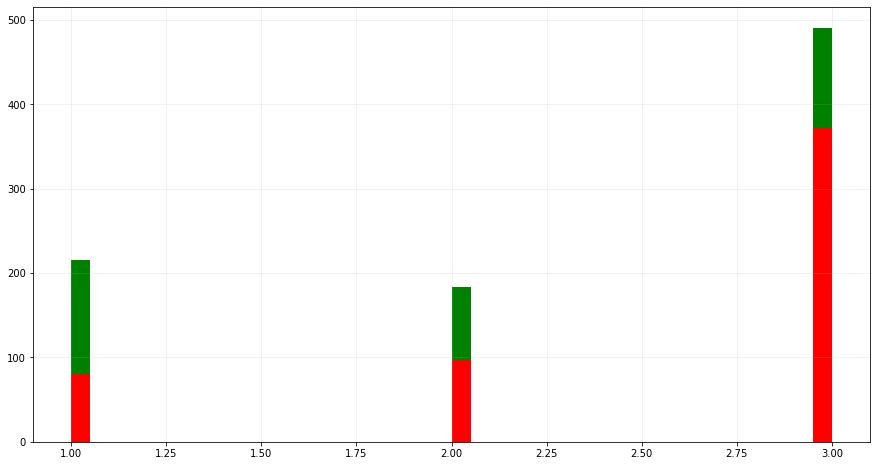

In [10]:
plot_feature("Pclass")

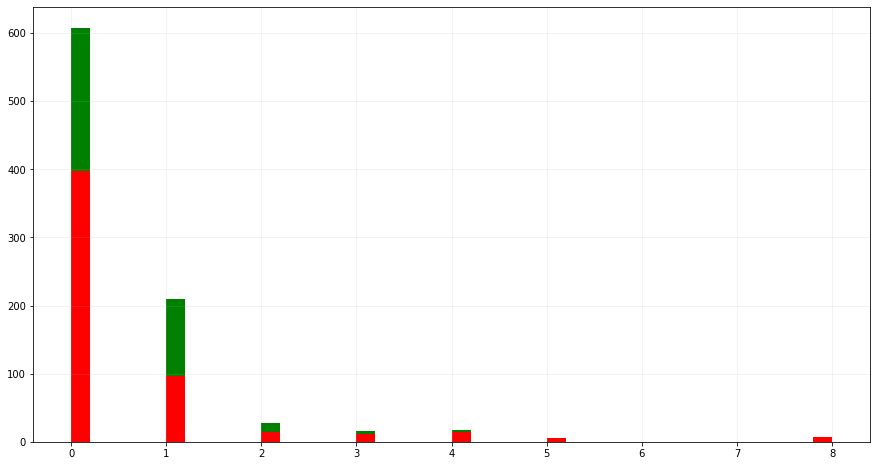

In [11]:
plot_feature("SibSp")

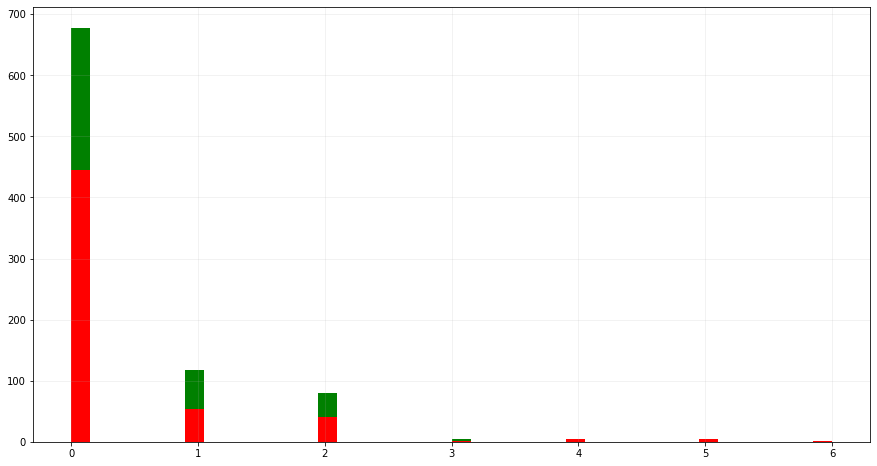

In [12]:
plot_feature("Parch")

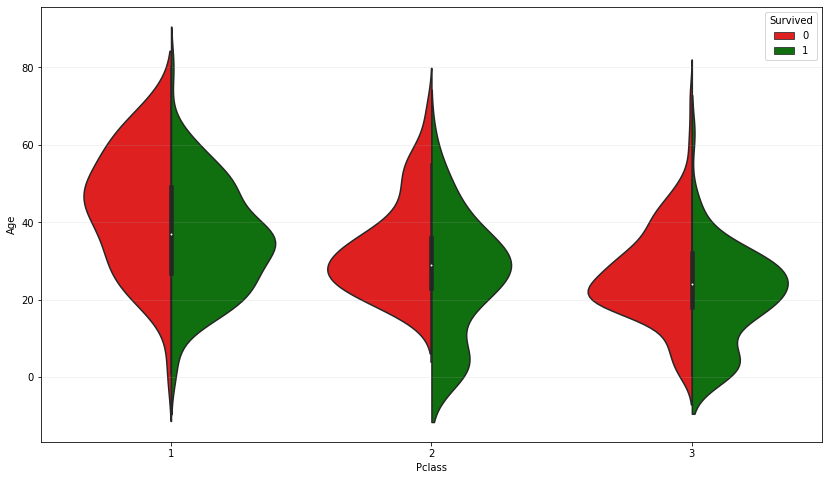

In [13]:
plt.figure(figsize=[14, 8])
plt.grid(alpha=0.2)
sns.violinplot(x="Pclass", 
               y="Age", 
               hue="Survived",
               data=dataset_train,
               split=True,
               palette=["r", "g"]
              )
plt.show()

In [14]:
for feature in dataset_train.columns:
    print(feature, dataset_train[feature].nunique())

PassengerId 891
Survived 2
Pclass 3
Name 891
Sex 2
Age 88
SibSp 7
Parch 7
Ticket 681
Fare 248
Cabin 147
Embarked 3
Died 2


# Processing the features

In [15]:
global status
status = {}
for column in dataset_train.columns:
    status[column] = False

def change_status(features):
    for feature in features:
        assert feature in status
        status[feature] = True

In [16]:
def combine(dataset_train, dataset_test):
    labels = dataset_train["Survived"]
    dataset_train = dataset_train.drop(["Survived", "Died"], axis=1)
    
    combined = pd.concat([dataset_train, dataset_test], axis=0)
    combined.reset_index(inplace=True)
    return combined, labels

In [17]:
def process_name(dataset):
    
    Title_Dictionary = {
    "Capt": "Officer",
    "Col": "Officer",
    "Major": "Officer",
    "Jonkheer": "Royalty",
    "Don": "Royalty",
    "Sir" : "Royalty",
    "Dr": "Officer",
    "Rev": "Officer",
    "the Countess":"Royalty",
    "Mme": "Mrs",
    "Mlle": "Miss",
    "Ms": "Mrs",
    "Mr" : "Mr",
    "Mrs" : "Mrs",
    "Miss" : "Miss",
    "Master" : "Master",
    "Lady" : "Royalty"
    }
    
    dataset["title"] = dataset["Name"].map(lambda string: string.split(",")[1].split()[0].replace(".", "").strip()).map(Title_Dictionary)
    dataset["title"] = dataset["title"].fillna(dataset["title"].value_counts().keys()[0])
    dummies = pd.get_dummies(dataset["title"])
    dataset = dataset.drop(["Name", "PassengerId", "index", "title"], axis=1)
    dataset = pd.concat([dataset, dummies], axis=1)
    return dataset

In [57]:
combined, labels = combine(dataset_train, dataset_test)
combined = process_name(combined)
display(combined)
change_status(["Name"])

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Master,Miss,Mr,Mrs,Officer,Royalty
0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,0,1,0,0,0
1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,0,0,0,1,0,0
2,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,1,0,0,0,0
3,1,female,35.0,1,0,113803,53.1000,C123,S,0,0,0,1,0,0
4,3,male,35.0,0,0,373450,8.0500,NaN,S,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,3,male,NaN,0,0,A.5. 3236,8.0500,NaN,S,0,0,1,0,0,0
1305,1,female,39.0,0,0,PC 17758,108.9000,C105,C,0,0,1,0,0,0
1306,3,male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,0,0,1,0,0,0
1307,3,male,NaN,0,0,359309,8.0500,NaN,S,0,0,1,0,0,0


#### Processing the Sex

In [58]:
combined.Sex = combined.Sex.map({"female":0, "male":1})
change_status(["Sex"])

#### Processing the Fare

In [59]:
combined.Fare.fillna(combined.Fare.mean(), inplace=True)
change_status(["Fare"])

#### Processing the Ticket
Still have no idea, maybe drop them

In [60]:
combined.drop("Ticket", axis=1, inplace=True)

#### Processing the Embarked

In [61]:
dummies = pd.get_dummies(combined.Embarked)
combined = pd.concat([combined, dummies], axis=1)
combined.drop("Embarked", axis=1, inplace=True)

In [62]:
display(combined)
combined.info()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Master,Miss,Mr,Mrs,Officer,Royalty,C,Q,S
0,3,1,22.0,1,0,7.2500,NaN,0,0,1,0,0,0,0,0,1
1,1,0,38.0,1,0,71.2833,C85,0,0,0,1,0,0,1,0,0
2,3,0,26.0,0,0,7.9250,NaN,0,1,0,0,0,0,0,0,1
3,1,0,35.0,1,0,53.1000,C123,0,0,0,1,0,0,0,0,1
4,3,1,35.0,0,0,8.0500,NaN,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,3,1,NaN,0,0,8.0500,NaN,0,0,1,0,0,0,0,0,1
1305,1,0,39.0,0,0,108.9000,C105,0,0,1,0,0,0,1,0,0
1306,3,1,38.5,0,0,7.2500,NaN,0,0,1,0,0,0,0,0,1
1307,3,1,NaN,0,0,8.0500,NaN,0,0,1,0,0,0,0,0,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Pclass   1309 non-null   int64  
 1   Sex      1309 non-null   int64  
 2   Age      1046 non-null   float64
 3   SibSp    1309 non-null   int64  
 4   Parch    1309 non-null   int64  
 5   Fare     1309 non-null   float64
 6   Cabin    295 non-null    object 
 7   Master   1309 non-null   uint8  
 8   Miss     1309 non-null   uint8  
 9   Mr       1309 non-null   uint8  
 10  Mrs      1309 non-null   uint8  
 11  Officer  1309 non-null   uint8  
 12  Royalty  1309 non-null   uint8  
 13  C        1309 non-null   uint8  
 14  Q        1309 non-null   uint8  
 15  S        1309 non-null   uint8  
dtypes: float64(2), int64(4), object(1), uint8(9)
memory usage: 83.2+ KB


#### Processing the age

In [63]:
import copy
grouped_age_train = combined.iloc[:891].groupby(["SibSp", "Sex", "Pclass"]).median()
grouped_age_train = grouped_age_train.reset_index()[["SibSp", "Sex", "Pclass", "Age"]]

In [64]:
def fill_na(row):
    return grouped_age_train[(grouped_age_train["SibSp"] == row["SibSp"]) & 
                             (grouped_age_train["Sex"] == row["Sex"]) &
                             (grouped_age_train["Pclass"] == row["Pclass"])]["Age"].values[0]

In [65]:
combined.Age = combined.apply(lambda row: fill_na(row) if np.isnan(row["Age"]) else row["Age"], axis=1)
combined.Age.fillna(combined.Age.median(), inplace=True)
combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Pclass   1309 non-null   int64  
 1   Sex      1309 non-null   int64  
 2   Age      1309 non-null   float64
 3   SibSp    1309 non-null   int64  
 4   Parch    1309 non-null   int64  
 5   Fare     1309 non-null   float64
 6   Cabin    295 non-null    object 
 7   Master   1309 non-null   uint8  
 8   Miss     1309 non-null   uint8  
 9   Mr       1309 non-null   uint8  
 10  Mrs      1309 non-null   uint8  
 11  Officer  1309 non-null   uint8  
 12  Royalty  1309 non-null   uint8  
 13  C        1309 non-null   uint8  
 14  Q        1309 non-null   uint8  
 15  S        1309 non-null   uint8  
dtypes: float64(2), int64(4), object(1), uint8(9)
memory usage: 83.2+ KB


#### removing the Cabin

In [66]:
combined.drop("Cabin", axis=1, inplace=True)

#### Converting the Pclass to dummies

In [70]:
dummies = pd.get_dummies(combined.Pclass)
dummies.columns = ["Pclass1", "Pclass2", "Pclass3"]
combined = pd.concat([combined, dummies], axis=1)
combined.drop("Pclass", axis=1, inplace=True)

In [71]:
display(combined)
combined.info()

,Sex,Age,SibSp,Parch,Fare,Master,Miss,Mr,Mrs,Officer,Royalty,C,Q,S,Pclass1,Pclass2,Pclass3
0,1,22.0,1,0,7.2500,0,0,1,0,0,0,0,0,1,0,0,1
1,0,38.0,1,0,71.2833,0,0,0,1,0,0,1,0,0,1,0,0
2,0,26.0,0,0,7.9250,0,1,0,0,0,0,0,0,1,0,0,1
3,0,35.0,1,0,53.1000,0,0,0,1,0,0,0,0,1,1,0,0
4,1,35.0,0,0,8.0500,0,0,1,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1,27.0,0,0,8.0500,0,0,1,0,0,0,0,0,1,0,0,1
1305,0,39.0,0,0,108.9000,0,0,1,0,0,0,1,0,0,1,0,0
1306,1,38.5,0,0,7.2500,0,0,1,0,0,0,0,0,1,0,0,1
1307,1,27.0,0,0,8.0500,0,0,1,0,0,0,0,0,1,0,0,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 17 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Sex      1309 non-null   int64  
 1   Age      1309 non-null   float64
 2   SibSp    1309 non-null   int64  
 3   Parch    1309 non-null   int64  
 4   Fare     1309 non-null   float64
 5   Master   1309 non-null   uint8  
 6   Miss     1309 non-null   uint8  
 7   Mr       1309 non-null   uint8  
 8   Mrs      1309 non-null   uint8  
 9   Officer  1309 non-null   uint8  
 10  Royalty  1309 non-null   uint8  
 11  C        1309 non-null   uint8  
 12  Q        1309 non-null   uint8  
 13  S        1309 non-null   uint8  
 14  Pclass1  1309 non-null   uint8  
 15  Pclass2  1309 non-null   uint8  
 16  Pclass3  1309 non-null   uint8  
dtypes: float64(2), int64(3), uint8(12)
memory usage: 66.6 KB


#### Processing the familysize

In [82]:
combined["family_size"] = combined["SibSp"] + combined["Parch"]

In [83]:
from sklearn.ensemble import RandomForestClassifier

In [84]:
clf = RandomForestClassifier()
clf.fit(combined[:891], labels)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [85]:
features = clf.feature_importances_
names = combined.columns

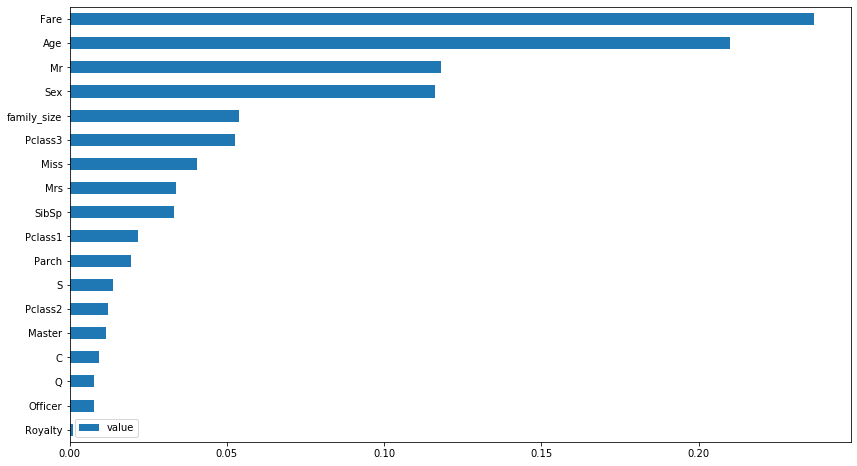

In [86]:
df = pd.DataFrame(features, index=names, columns=["value"])
df.sort_values(by="value", inplace=True, ascending=True)
df.plot(kind="barh", figsize=[14, 8])

In [131]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

num_features = None
best_features = df.index[:num_features]
small_combined = combined[best_features]
clf = RandomForestClassifier()

parameters = {
    "n_estimators":[30, 60, 90],
    "criterion": ["gini", "entropy"],
    "max_depth": [5, 10, None]
}


GS = GridSearchCV(clf, 
                  parameters,
                  cv=10,
                 verbose=1)

GS.fit(combined[:891], 
       labels)


Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:   17.9s finished


GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rand

In [133]:
print("The best score", GS.best_score_)
print("The best parameters", GS.best_params_)

The best score 0.8316729088639201
The best parameters {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 90}


In [125]:
predictions = GS.best_estimator_.predict(combined[891:])

In [126]:
results = pd.concat([dataset_test["PassengerId"], pd.Series(predictions)], axis=1)
results.columns = ["PassengerId", "Survived"]
results.to_csv("results_ver3.csv", index=False)